**Negrea Oana Veronica** (SM2001558)

Università degli Studi di Trieste, A.A. 2023/2024

Esame di Tecniche di Rappresentazione e Modellizzazione Dati


# Esercizio: *Parameter Regression ML*

## Introduzione

Il tasso di formaizone stellare (*star formation rate density*, SFRD) è una quantità che dipende dall'età dell'Universo in cui la si misura (*redshift*, z) e da alcuni parametri caratteristici del modello cosmologico e astrofisico. Indicando questi ultimi con $\vec{\theta}$, la SFRD può essere espressa come:

\begin{equation}
  SFRD = f(z,\vec{\theta})
\end{equation}




Lo scopo dell'esercizio è approssimare con una rete neuronale la funzione inversa $f^{-1}(SFRD(z))=\vec{\theta}$ e ricavare i valori dei parametri cosmologici e astrofisici da cui dipende la grandezza in esame. Vengono utilizzate misure di $SFRD(z)$ ricavate da un insieme di 1000 simulazioni idrodinamiche, ognuna ottenuta con un diverso set dei parametri:

\begin{equation}
  \vec{\theta} = (\Omega_m, \sigma_8, A_{SN1}, A_{SN2}, A_{AGN1}, A_{AGN_2})
\end{equation}

I primi due elementi del vettore dato sono parametri cosmologici legati alla densità di materia e all'ampiezza delle fluttuazioni del campo di materia a $z=0$ mentre i rimanenti rimandano all'efficienza dei feedback energetici ottenuti da esplosioni di supernovae e nuclei galattici attivi.

## Esecuzione dell'esercizio


L'esercizio proposto può essere suddiviso in due parti di cui la prima prevede l'apertura e la visualizzazione dei dati forniti mentre la seconda riguarda la creazione di una rete neuronale finalizzata alla stima dei parametri introdotti in precedenza.

Nella seguente cella vengono importate alcune librerie esterne, da sfruttare nello svolgimento della prova. In particolare, *NumPy* e *PyTorch* vengono impiegate nella creazione e nella gestione di array e tensori utili all'analisi dei dati in input mentre *Matplotlib* permette la realizzazione di grafici fondamentali per la visualizzazione dei dati stessi e dei risultati prodotti dalla rete neuronale.

In [69]:
# caricamento di librerie esterne

import numpy as np
import matplotlib.pyplot as plt

import sys,os,time

import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

### 1. Visualizzazione dei dati

In [70]:
# lettura dei dati

SFRD = np.load('SFRH_IllustrisTNG.npy')
params = np.loadtxt('params_IllustrisTNG.txt', skiprows = 1)

In questa sezione viene descritto il processo di creazione di un grafico a partire dai dati forniti. Nello specifico, viene rappresentato l'andamento della funzione $SFRD(z)$ contestualmente a 5 delle 1000 simulazioni idrodinamiche di cui si è parlato in precedenza. Queste vengono selezionate in maniera aleatoria a partire dal set iniziale tramite la definizione di un array contenente 5 interi casuali appartenenti all'intervallo [0,999] dove la scelta degli estremi è dettata dalle norme relative all'indicizzazione degli array *NumPy*.

Siccome ogni simulazione è caratterizzata da un dato insieme di parametri cosmologici e astrofisici, i valori di questi ultimi vengono riportati nella legenda.

In [71]:
# generazione di interi casuali in [0,999]

selected_indexes = np.random.randint(1000, size = 5)
selected_indexes

array([983, 530, 106,  21,  67])

In [72]:
# estrazione degli elementi corrispondenti agli indici selezionati

selected_SFRD = SFRD[selected_indexes]
selected_params = params[selected_indexes]

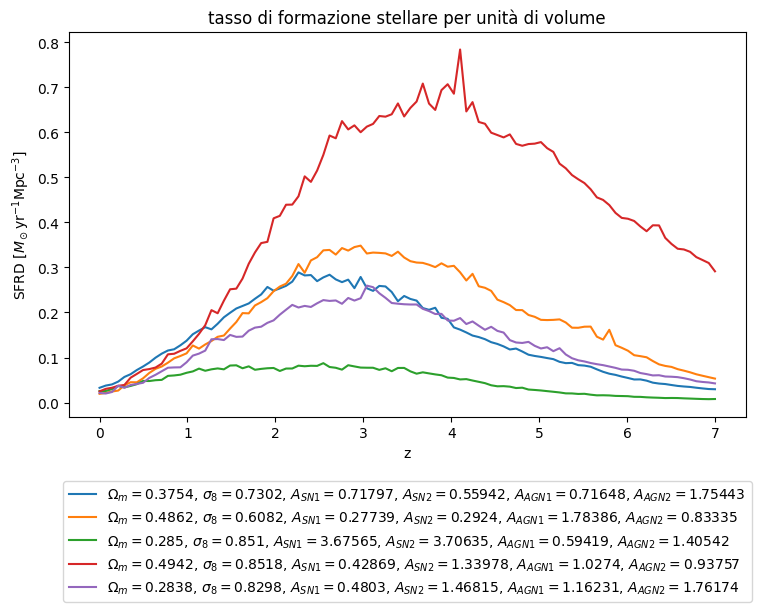

In [73]:
# creazione e visualizzazione del grafico

z = np.linspace(0.0, 7.0, 100)

label = ['\Omega_m', "\sigma_8", "A_{SN1}", "A_{SN2}", "A_{AGN1}", "A_{AGN2}"]

plt.figure(figsize=(8, 7))

for i in range(selected_SFRD.shape[0]):
    plt.plot(z, selected_SFRD[i], label=', '.join([f'${label[j]} = {selected_params[i, j]}$' for j in range(6)]))

plt.xlabel('z')
plt.ylabel(r'${\rm SFRD}\,\,[M_\odot {\rm yr}^{-1}{\rm Mpc}^{-3}]$')
plt.title('tasso di formazione stellare per unità di volume')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
plt.tight_layout()
plt.show()

### 2. Machine Learning

### 2.1 Aspetti preliminari

In [74]:
if torch.cuda.is_available():
    print("CUDA Available")
    device = torch.device('cuda')
else:
    print('CUDA Not Available')
    device = torch.device('cpu')

CUDA Available


In linea con quanto anticipato in sede introduttiva, la seconda parte dell'esercizio prevede la creazione di una rete neuronale per la stima degli elementi del vettore $\vec\theta$.

In primo luogo si definisce un set di parametri e iperparametri i cui valori sono fondamentali per garantire il corretto funzionamento della rete e l'efficienza del processo di apprendimento. Tra questi assume particolare importanza il *learning rate* (lr), che controlla l'ampiezza degli spostamenti compiuti dalla rete sulla *loss function* e di conseguenza il tasso di aggiornamento dei parametri da stimare. Valgono infatti le seguenti relazioni:

\begin{equation}
  L(\vec{\theta}) = \frac{1}{N} \sum_{i=1}^{N}(\vec{\theta_{NN}} - \vec{\theta_{\text{true}}})^2
\end{equation}

\begin{equation}
  \vec{\theta_{k+1}} = \vec{\theta_k} - \lambda \vec{\nabla_{\theta}}L(\vec{\theta})
\end{equation}

dove la *loss function* viene indicata con $L(\vec{\theta})$ e il *learning rate* con $\lambda$. Il parametro k è infine l'indice di epoca nella discesa lungo il gradiente.

In [75]:
# definizione del set di parametri e iperparametri

seed           = 1
min_valid_loss = 1e7
batch_size     = 32                        # numero di elementi per ciascun batch
lr             = 3e-4                      # learning rate
wd             = 0.0                       # weight decay
dr             = 0.1                       # dropout rate
epochs         = 5000                      # numero di iterazioni (epoche)

f_SFRD         = 'SFRH_IllustrisTNG.npy'   # file contenente i dati di SFRD
f_params       = 'params_IllustrisTNG.txt' # file contenente i valori dei parametri
f_model        = 'best_model.pt'

Preliminarmente alle operazioni di creazione e ottimizzazione della rete neuronale è necessario preparare i dati all'analisi e in particolare essi vengono divisi in tre categorie secondo lo schema: 70% *training*, 15% *validation* e 15% *test*. Si ricorda che soltanto le prime due classi vengono fornite alla rete neuronale a scopo di apprendimento. I dati appartenenti al *test set* vengono infatti sfruttati alla fine del processo per verificare il corretto funzionamento e l'affidabilità del modello implementato.

Dal punto di vista pratico, la creazione dei *data set* avviene per mezzo della classe *make dataset* e della funzione *create_dataset* che la richiama. Entrambi gli oggetti sfruttano le funzionalità del pacchetto *PyTorch*, particolarmente efficace nell'ambito del Machine Learning.

I dati da analizzare vengono manipolati per migliorare la stabilità e l'efficienza del modello. Nello specifico, si usano le seguenti formule per la standardizzazione dei dati relativi alla funzione SFRD e la normalizzazione dei parametri da stimare:

\begin{equation}
  \tilde{x} = \frac{x-\bar{x}}{\sigma_x}
\end{equation}

\begin{equation}
  \tilde{x} = \frac{x-\text{min(x)}}{\text{max(x)}-\text{min(x)}}
\end{equation}

Un aspetto fondamentale della creazione dei data set è il mescolamento dei dati. Questo processo permette infatti di ridurre il bias permettendo alla rete di formarsi e allenarsi su insiemi variegati di dati migliorandone le performance.

In [76]:
# preparazione dei dati

def create_dataset(mode, f_SFRD, f_params, batch_size, seed):
    data_set = make_dataset(mode, f_SFRD, f_params, seed)
    return DataLoader(dataset = data_set, batch_size = batch_size, shuffle = True)

In [77]:
class make_dataset():
    def __init__(self, mode, f_SFRD, f_params, seed):

        SFRD = np.load(f_SFRD)
        params = np.loadtxt(f_params, skiprows = 1)

        # standardizzazione SFRD
        SFRD[np.where(SFRD==0.0)] = 1e-12  # sostituzione di eventuali valori nulli
        mean = np.mean(SFRD, axis=0, dtype=np.float64)
        std  = np.std(SFRD,  axis=0, dtype=np.float64)
        SFRD = (SFRD - mean)/std

        # normalizzazione parametri
        min_params = np.min(params, axis=0)
        max_params = np.max(params, axis=0)
        params = (params - min_params)/(max_params - min_params)

        simulations = SFRD.shape[0]
        bins = SFRD.shape[1]

        # definizione delle classi
        if   mode=='train':
            size, offset = int(simulations*0.70), int(simulations*0.00)
        elif mode=='valid':
            size, offset = int(simulations*0.15), int(simulations*0.70)
        elif mode=='test':
            size, offset = int(simulations*0.15), int(simulations*0.85)
        elif mode=='all':
            size, offset = int(simulations*1.00), int(simulations*0.00)
        else:    raise Exception('Wrong name!')

        # definizione delle dimensioni degli array contententi i dati in input e output
        self.size   = size
        self.input  = torch.zeros((size,bins), dtype=torch.float) # SFRD
        self.output = torch.zeros((size,6), dtype=torch.float) # parametri

        # mescolamento dei dati
        np.random.seed(seed)
        indexes = np.arange(simulations)
        np.random.shuffle(indexes)
        indexes = indexes[offset:offset+size]

        # creazione degli array di input e output
        self.input  = torch.tensor(SFRD[indexes], dtype=torch.float32)
        self.output = torch.tensor(params[indexes], dtype=torch.float32)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

Le ultime righe della cella precedente fanno riferimento a due metodi speciali di Python che vengono spesso usati in classi che coinvolgono insiemi di dati come liste, tuple e dizionari e permettono rispettivamente di ottenere le dimensioni di un oggetto e accedere ai suoi elementi.

In [78]:
# creazione dei dataset

train_loader = create_dataset('train', f_SFRD, f_params, batch_size, seed) #training dataset
valid_loader = create_dataset('valid', f_SFRD, f_params, batch_size, seed) #validation dataset

### 2.2 Ottimizzazione dei parametri

Il corretto funzionamento di una rete neuronale richiede di trovare giusto bilanciamento dei parametri che la caratterizzano. Per fare ciò si implementa l'ottimizzatore Optuna e lo si usa per studiare i seguenti iperparametri: *learning rate*, *numero di epoche*, numero di neuroni per *hidden layer* e numero di *hidden layer*. Il loro significato verrà chiarito in seguito.

In [79]:
!pip install optuna
import optuna

All'interno dell'ottimizzatore vengono definite una *loss function* e un modello della stessa forma di quelli della rete che si vuole ottimizzare. Questo oggetto viene allenato sul set di dati definito nella sezione precedente con valori degli iperparametri che vengono selezionati casualmente all'interno di un certo range di definizione. Questa operazione è svolta dalla funzione *trial.suggest* ed è di fondamentale importanza in quanto l'ottimizzatore lavora per tentativi scegliendo diverse combinazioni degli iperparametri da stimare e cercando quella che determina il risultato migliore.

In [80]:
loss_func = nn.MSELoss()  #scarto quadratico medio

def build_model_custom(trial):

    # suggerimento del numero di strati nascosti
    n_layers = trial.suggest_int("n_layers", 1, 10)
    layers = []

    in_features = 100
    out_features = 6

    for i in range(n_layers):

        # suggerimento del numero di neuroni per ogni strato
        hidden_size = trial.suggest_int("hidden_size", 10, 100)

        layers.append(nn.Linear(in_features, hidden_size))
        layers.append(nn.ReLU())

        in_features = hidden_size

    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())

    return nn.Sequential(*layers)

def train_and_evaluate(hparam, model, trial):

    optimizer = torch.optim.Adam(model.parameters(), lr=hparam['learning_rate'], betas=(0.5, 0.999), weight_decay=wd)

    epochs=hparam['epochs']

    min_valid_loss_param = min_valid_loss

    for epoch in range(epochs):

        # training
        train_loss, points = 0.0, 0
        model.train()
        for SFRD_train, params_train in train_loader:

            # dimensione del batch
            bs = SFRD_train.shape[0]

            # spostamento dei dati sulla GPU
            params_train = params_train.to(device)
            SFRD_train   = SFRD_train.to(device)

            # calcolo del valore previsto dalla rete
            params_pred  = model(SFRD_train)

            # calcolo della loss function
            loss = loss_func(params_pred, params_train)
            train_loss = train_loss + (loss.item())*bs # .item() estrae lo scalare dal tensore
            points = points + bs

            # ottimizzazione dei parametri
            optimizer.zero_grad() # azzeramento del gradiente
            loss.backward()       # calcolo del nuovo gradiente
            optimizer.step()      # calcolo dei nuovi parametri usando l'algoritmo di ottimizzazione

        # calcolo del valore medio
        train_loss /= points

        # validation
        valid_loss, points = 0.0, 0
        model.eval()
        for SFRD_val, params_val in valid_loader:
            with torch.no_grad():

               # dimensione del batch
                bs = SFRD_val.shape[0]

                # spostamento dei dati sulla GPU
                params_val = params_val.to(device)
                SFRD_val   = SFRD_val.to(device)

                # calcolo del valore previsto dalla rete
                params_pred = model(SFRD_val)
                valid_loss = valid_loss + (loss_func(params_pred, params_val).item())*bs
                points     = points + bs

        # calcolo del valore medio
        valid_loss /= points

        # salvataggio del valore più basso
        if valid_loss<min_valid_loss_param:
            min_valid_loss_param = valid_loss

        trial.report(min_valid_loss_param, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return min_valid_loss_param

def objective(trial):

    hparams = {'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True),
              'epochs': trial.suggest_int("epochs", 100, 1000)}

    model = build_model_custom(trial)
    model.cuda()

    accuracy = train_and_evaluate(hparams, model, trial)

    return accuracy

In [81]:
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.PercentilePruner(80.))
study.optimize(objective, n_trials=100)

[I 2024-03-08 17:43:30,815] A new study created in memory with name: no-name-9cd86bdc-75cf-4d6b-ae6b-17173220a516
[I 2024-03-08 17:43:53,109] Trial 0 finished with value: 0.04493155285716057 and parameters: {'learning_rate': 6.092900719053658e-05, 'epochs': 477, 'n_layers': 3, 'hidden_size': 45}. Best is trial 0 with value: 0.04493155285716057.
[I 2024-03-08 17:44:01,354] Trial 1 finished with value: 0.09932305117448172 and parameters: {'learning_rate': 2.2626774443367742e-06, 'epochs': 174, 'n_layers': 3, 'hidden_size': 67}. Best is trial 0 with value: 0.04493155285716057.
[I 2024-03-08 17:45:08,878] Trial 2 finished with value: 0.09512761155764261 and parameters: {'learning_rate': 1.2450397607271586e-05, 'epochs': 893, 'n_layers': 10, 'hidden_size': 88}. Best is trial 0 with value: 0.04493155285716057.
[I 2024-03-08 17:45:55,762] Trial 3 finished with value: 0.06085180242856344 and parameters: {'learning_rate': 0.0004987234539181539, 'epochs': 633, 'n_layers': 9, 'hidden_size': 51}. 

Siccome il funzionamento dell'ottimizzatore Optuna si basa sulla scelta casuale di un set di iperparametri iniziali, non è raro ottenere risultati di bassa qualità. Risulta quindi utile implementare un sistema di riconoscimento precoce dei tentativi fallimentari. Troncando questi ultimi è possibile risparmiare tempo e far compiere al programma un numero maggiore di prove, fatto che determina chiaramente un miglioramento dei risultati ottenuti.  

In [82]:
best_trial = study.best_trial

for key, value in best_trial.params.items():
    print("{}: {}".format(key, value))

learning_rate: 0.0005023705074168197
epochs: 672
n_layers: 7
hidden_size: 64


Il seguente grafico mostra quanto i diversi iperparametri studiati tramite Optuna influiscono sul corretto funzionamento della rete neuronale. Si tratta di un'informazione molto utile nel caso ci sia bisogno di aggiustare ulteriormente i valori per ottenere risultati soddisfacenti.

In [83]:
optuna.visualization.plot_param_importances(study)

### 2.3 Creazione della rete neuronale


La rete neuronale viene ridefinita utilizzando i valori degli iperparametri suggeriti da Optuna e implementando un'architettura del tipo *Fully Connected Linear Network*. La funzione di attivazione scelta in questo caso è il rettificatore (*rectified linear unit*, ReLU). Data inoltre la natura ripetitiva della rete neuronale e delle operazioni che essa deve svolgere, la si affida all'unità di elaborazione grafica (GPU) dal momento che questa è molto più efficiente della CPU nello svolgimento di compiti come quelli richiesti.

In [45]:
# definizione dell'architettura della rete e aggiornamento degli iperparametri

patience = 100
stop_criterion = 200

lr             = best_trial.params['learning_rate']
epochs         = best_trial.params['epochs']
hidden_size = best_trial.params['hidden_size']

In [84]:
model = nn.Sequential(
            nn.Linear(100, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 6))

# spostamento dell'architettura alla GPU
model.to(device=device)

# calcolo del numero totale di parametri
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 72574


Il numero di parametri della rete neuronale dipende dal numero di input, output e neuroni nascosti tramite la relazione:

\begin{equation}
    N_{\rm p} =(N_{\rm input}+1)×N_{\rm hidden}+(N_{\rm hidden}+1)×N_{\rm ouput}
\end{equation}

dove l'addendo +1 è dovuto al termine di bias associato a ogni strato.

In [85]:
# definizione di loss function e ottimizzatore

loss_func = nn.MSELoss()  #scarto quadratico medio
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

 Nella seguente cella si presenta l'allenamento della rete sui dati contenuti all'interno del *training set* e del *validation set*. Le prime righe di codice servono a introdurre alcuni oggetti utili al processo, come ad esempio lo *scheduler*, che sfrutta il parametro *patience* sopra introdotto per diminuire il *learning rate* quando questo diventa inefficace. Si definiscono inoltre anche gli array in cui vengono memorizzati, di epoca in epoca, i valori delle due *loss function* e il parametro *epoch_best_model*.

 Viene successivamente avviato un ciclo *for* che usa come indice il numero di epoche (*epochs*). Al suo interno il dataset viene suddiviso in sottoinsiemi di dimensione minore (*batch*) e il programma calcola il valore della *loss function* su ogni singolo *batch* per poi sfruttare i risultati ottenuti al fine di trovare la media sull'intero set di dati.

 L'ottimizzazione dei parametri si basa sul metodo della discesa del gradiente.

 Nell'ambito del processo di *validation* vengono ripetute le stesse operazioni svolte durante l'allenamento, ma su un set di dati differente. In questo caso, inoltre, non c'è bisogno del calcolo del gradiente in quanto la fase di *validation* prevede la sola valutazione del modello e non anche la modifica dei parametri.

 Viene infine introdotto un cronometro che misura il tempo di esecuzione dei processi descritti.

In [86]:
start = time.time() # avvio cronometro

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience,
                                           min_lr= 1.0e-6, verbose=True)
epoch_best_model = 0

for epoch in range(epochs):

    # training
    train_loss, points = 0.0, 0 # la variabile points tiene conto della quantità
                                # di dati analizzati ad ogni epoca ed è utile per
                                # calcolare il valor medio della loss function
    model.train()
    for SFRD_train, params_train in train_loader:

        # dimensione del batch
        bs = SFRD_train.shape[0]

        # spostamento dei dati sulla GPU
        params_train = params_train.to(device)
        SFRD_train   = SFRD_train.to(device)

        # calcolo del valore previsto dalla rete
        params_pred  = model(SFRD_train)

        # calcolo della loss function
        loss = loss_func(params_pred, params_train)
        train_loss = train_loss + (loss.item())*bs # .item() estrae lo scalare dal tensore
        points = points + bs

        # ottimizzazione dei parametri
        optimizer.zero_grad() # azzeramento del gradiente
        loss.backward()       # calcolo del nuovo gradiente
        optimizer.step()      # calcolo dei nuovi parametri usando l'algoritmo di ottimizzazione

    # calcolo del valor medio
    train_loss = train_loss/points
    train_value[epoch] = train_loss

    # validation
    valid_loss, points = 0.0, 0
    model.eval()
    for SFRD_val, params_val in valid_loader:
        with torch.no_grad():   # siccome il valore del gradiente non è necessario,
                                # esso non viene calcolato per non occupare memoria
                                # inutilmente

            # dimensione del batch
            bs = SFRD_val.shape[0]

            # spostamento dei dati sulla GPU
            params_val = params_val.to(device)
            SFRD_val   = SFRD_val.to(device)

            # calcolo del valore previsto dalla rete
            params_pred = model(SFRD_val)
            #valid_loss = valid_loss + (loss_func(params_pred, params_val).item())*bs
            valid_loss += (loss_func(params_pred, params_val).item())*bs
            points     = points + bs

    # calcolo del valor medio
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss)

    # ricerca del modello migliore
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss:
        torch.save(model.state_dict(), f_model)
        min_valid_loss = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break


stop = time.time() # spegnimento cronometro
print('Time taken (seconds):', "{:.4f}".format(stop-start))

epoch:0, valid loss: 0.1893 (best-model)
epoch:1, valid loss: 0.0874 (best-model)
epoch:2, valid loss: 0.0769 (best-model)
epoch:3, valid loss: 0.0676 (best-model)
epoch:4, valid loss: 0.0607 (best-model)
epoch:5, valid loss: 0.0565 (best-model)
epoch:6, valid loss: 0.0562 (best-model)
epoch:7, valid loss: 0.0552 (best-model)
epoch:8, valid loss: 0.0542 (best-model)
epoch:9, valid loss: 0.0544
epoch:10, valid loss: 0.0535 (best-model)
epoch:11, valid loss: 0.0545
epoch:12, valid loss: 0.0528 (best-model)
epoch:13, valid loss: 0.0527 (best-model)
epoch:14, valid loss: 0.0525 (best-model)
epoch:15, valid loss: 0.0532
epoch:16, valid loss: 0.0528
epoch:17, valid loss: 0.0528
epoch:18, valid loss: 0.0537
epoch:19, valid loss: 0.0517 (best-model)
epoch:20, valid loss: 0.0548
epoch:21, valid loss: 0.0515 (best-model)
epoch:22, valid loss: 0.0519
epoch:23, valid loss: 0.0514 (best-model)
epoch:24, valid loss: 0.0519
epoch:25, valid loss: 0.0509 (best-model)
epoch:26, valid loss: 0.0510
epoch:

Il seguente grafico mette a confronto l'andamento della *loss function* calcolata nell'ambito delle fasi di *training* e *validation* al variare del numero di epoche. Ricordando che il valore di tale grandezza è correlato all'efficienza del processo di apprendimento che viene svolto dalla rete, bisogna aspettarsi di vedere due curve discendenti e che la *validation loss* sia sempre maggiore della *training loss*. Quest'ultima caratteristica è dovuta al fatto che, come già accennato nelle righe precedenti, la fase di *validation* non prevede il continuo aggiornamento dei parametri, cosa che caratterizza invece il *training*. Il grafico presentato si discosta dal modello atteso proprio su quest'ultima questione. Si può infatti notare che la *validation loss* è sempre minore della *training loss* suggerendo che la rete neuronale creata risulta più efficiente sui dati appartenenti al *validation* set. La peculiarità descritta potrebbe essere dovuta a un utilizzo eccessivo dei sistemi di ottimizzazione nell'ambito della fase di allenamento oppure a una cattiva scelta delle percentuali nella divisione del dataset iniziale nelle categorie di *training*, *validation* e *test*. In particolare, si può ipotizzare che il *validation* set sia eccessivamente ridotto in confronto al *training* set, per cui esso potrebbe risultare come una prova di verifica troppo semplice per la rete neuronale.

Si riporta che la variazione degli iperparametri e la modifica dell'architettura della rete (e in particolare della funzione di attivazione) non comporta un netto miglioramento dei risultati finali. Per questa ragione si può pensare che l'anomalia riscontrata sia frutto di cause concatenate.

Fatta eccezione per la caratteristica di cui si è discusso sopra, il grafico presentato può essere ritenuto un risultato soddisfacente dal momento che entrambe le *loss function* hanno un andamento decrescente, fatto che suggerisce che il modello sta imparando in maniera corretta ed efficace.

[]

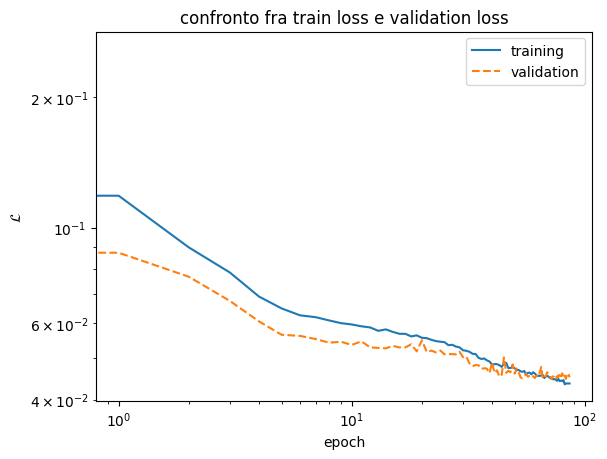

In [87]:
# realizzazione grafico

epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='training')
plt.plot(epoche,valid_value[:epoch_best_model],ls='--',label='validation')

plt.legend()
plt.title("confronto fra train loss e validation loss")
plt.xlabel("epoch")
plt.ylabel("$\mathcal{L}$")
plt.loglog()


La rete neuronale viene testata sul rimanente 15% dei dati iniziali. Dal punto di vista pratico, il *test* è caratterizzato da una struttura simile a quella dei processi di *training* e *validation*: vengono definiti innanzitutto degli array per la memorizzazione dei risultati ottenuti all'interno del ciclo *for* sottostante. Questi verranno poi sfruttati per realizzare un grafico a 6 pannelli, uno per ciascun parametro, che permetta il confronto tra i valori reali e quelli calcolati dalla rete.

In [88]:
test_loader = create_dataset('test', f_SFRD, f_params, batch_size, seed) #test dataset

# caricamento del best model e spostamento alla GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# test
SFRD_values=np.zeros((int(SFRD.shape[0]*0.15),100), dtype=np.float32)
params_true = np.zeros((int(params.shape[0]*0.15),6), dtype=np.float32)
params_NN = np.zeros((int(params.shape[0]*0.15),6), dtype=np.float32)

offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0

for SFRD_test, params_test in test_loader:
    with torch.no_grad():

        bs = SFRD_test.shape[0]

        # spostamento dei dati alla GPU
        SFRD_test   = SFRD_test.to(device)
        params_test = params_test.to(device)

        # calcolo dei valori previsti dalla rete
        params_pred = model(SFRD_test)

        # memorizzazione dei valori reali e calcolati dei parametri
        # spostamento dei dati alla CPU e traduzione in array Numpy

        SFRD_values[counter:counter+bs,:]=SFRD_test.cpu().numpy()
        params_true[counter:counter+bs,:]= params_test.cpu().numpy()
        params_NN[counter:counter+bs,:]= params_pred.cpu().numpy()

        test_loss += (loss_func(params_pred, params_test).item())*SFRD_test.shape[0]
        points += SFRD_test.shape[0]

        counter += bs

# calcolo del valore medio
test_loss /= points

print('test loss = %.3e'%test_loss)

test loss = 4.967e-02


L'immagine presentata di seguito permette di effettuare un confronto tra le stime ottenute per i parametri astrofisici e cosmologici contenuti in $\vec{\theta}$ e i rispettivi valori reali. Per agevolare la lettura e l'interpretazione dei grafici si è scelto di realizzare uno *scatterplot* a 6 pannelli, uno per ciascun parametro, ponendo in ascissa i valori reali dei parametri e in ordinata quelli predetti. In questo modo ci si aspetta che l'andamento dei punti raffigurati segua, almeno a grandi linee, quello della retta $y = x$, che corrisponderebbe a una stima perfetta.

Si osserva che soltanto 4 dei parametri studiati rimandano a un grafico con le caratteristiche desiderate, con risultati leggermente migliori nel caso di $A_{SN1}$ e $A_{AGN1}$. Si assume pertanto che i dati forniti relativamente alla densità di formazione stellare (SFRD) non siano particolarmente sensibili ai parametri $A_{SN2}$ e $A_{AGN2}$ per cui l'andamento dei punti risulta essere inconciliabile con le aspettative.

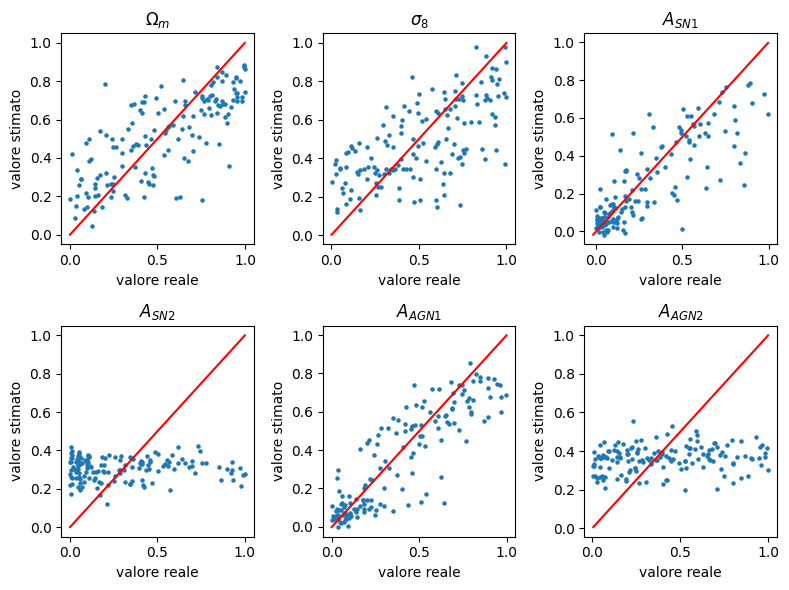

In [89]:
# produzione del grafico

label = ['$\Omega_m$', "$\sigma_8$", "$A_{SN1}$", "$A_{SN2}$", "$A_{AGN1}$", "$A_{AGN2}$"]

plt.figure(figsize=(8, 6))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.scatter(params_true[:, i], params_NN[:, i], s = 5)

    limits = [min(np.min(params_true[:, i]), np.min(params_NN[:, i])),
              max(np.max(params_true[:, i]), np.max(params_NN[:, i]))]

    plt.plot(limits, limits, color='red') # la retta fa riferimento a una stima perfetta
    plt.title(label[i])
    plt.xlabel('valore reale')
    plt.ylabel('valore stimato')

plt.tight_layout()
plt.show()

### 2.4 Stima dell'errore

In questa sezione viene proposta una variante dell'esercizio svolto in cui la rete neuronale viene usata per predirre non solo i valori degli elementi di $\vec{\theta}$, ma anche i relativi errori. Il procedimento adoperato risulta essere lo stesso del caso precedente e a cambiare è soltanto la *loss function*, che assume una forma leggermente diversa:

\begin{equation}
L(\vec{\theta}) = \log\sum_{i \in {\rm batch}} (\vec{\theta}_i-\hat{\vec{\theta}}_i)^2 + \log \sum_{i \in {\rm batch}} ((\vec{\theta}_i)^2 - \vec{\sigma_i}^2)^2
\end{equation}

In [90]:
# definizione dell'architettura della rete e aggiornamento degli iperparametri

seed           = 1
min_valid_loss = 1e7
lr             = best_trial.params['learning_rate']
epochs         = best_trial.params['epochs']
patience       = 100
stop_criterion = 200
hidden_size = best_trial.params['hidden_size']

lr = 0.0003
epochs = 800
hidden_size = 94

f_model = 'best_model.pt'

In [91]:
model = nn.Sequential(
            nn.Linear(100, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 12)) #in output ci sono i 6 parametri e i relativi errori

# spostamento dell'architettura alla GPU
model.to(device=device)

# calcolo del numero totale di parametri del modello
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# creazione dei dataset
train_loader = create_dataset('train', f_SFRD, f_params, batch_size, seed) #training dataset
valid_loader = create_dataset('valid', f_SFRD, f_params, batch_size, seed) #validation dataset

total number of parameters in the model = 73144


In [92]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self, params_sig_pred, params_train):
        num_params = params_sig_pred.shape[1] // 2
        loss = 0.0

        # si assume che parametri e rispettivi errori si alternino
        for i in range(num_params):
            loss += torch.log(torch.sum((params_train[:,i] - params_sig_pred[:,2*i])**2)) + torch.log(torch.sum(((params_train[:,i]-params_sig_pred[:,2*i])**2. - params_sig_pred[:,2*i+1]**2.)**2.))
        return loss

# definizione di loss function e ottimizzatore
loss_func = CustomLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=wd)

In [93]:
start = time.time() # accensione cronometro

train_value=np.zeros(epochs)
valid_value=np.zeros(epochs)

min_valid_loss_param=min_valid_loss

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience,
                                           min_lr= 1.0e-6, verbose=True)

epoch_best_model = 0

for epoch in range(epochs):

    # training
    train_loss, points = 0.0, 0
    model.train()
    for SFRD_train, params_train in train_loader:

         # dimensione del batch
        bs = SFRD_train.shape[0]

        # spostamento dei dati sulla GPU
        params_train = params_train.to(device)
        SFRD_train   = SFRD_train.to(device)

        # calcolo del valore previsto dalla rete
        params_sig_pred  = model(SFRD_train)

        # calcolo della loss function
        loss = loss_func(params_sig_pred, params_train)
        train_loss += (loss.item())
        points     += bs

        # ottimizzazione dei parametri
        optimizer.zero_grad() # azzeramento del gradiente
        loss.backward()       # calcolo del nuovo gradiente
        optimizer.step()      # calcolo dei nuovi parametri usando l'algoritmo di ottimizzazione


    # calcolo del valor medio
    train_loss /= points
    train_value[epoch]=train_loss


    # validation
    valid_loss, points = 0.0, 0
    model.eval()
    for SFRD_val, params_val in valid_loader:
        with torch.no_grad():

             # dimensione del batch
            bs = SFRD_val.shape[0]

            # spostamento dei dati sulla GPU
            params_val = params_val.to(device)
            SFRD_val   = SFRD_val.to(device)

            # calcolo del valore previsto dalla rete
            params_sig_pred  = model(SFRD_val)
            valid_loss += (loss_func(params_sig_pred, params_val).item())
            points     += bs

    # calcolo del valore medio
    valid_loss /= points
    valid_value[epoch]=valid_loss

    scheduler.step(valid_loss)

    # ricerca del modello migliore
    print(f'epoch:{epoch}, valid loss: {valid_loss:.4f}', end='')
    if valid_loss<min_valid_loss_param:
        torch.save(model.state_dict(), f_model)
        min_valid_loss_param = valid_loss
        epoch_best_model=epoch
        print(' (best-model)')
    else:
        print('')

    if epoch - epoch_best_model > stop_criterion:
        print ('Training stop at epoch:',epoch,' because the best model does not imporved after ',stop_criterion,' epochs')
        break

stop = time.time() # spegnimento cronometro

print('Time taken (seconds):', "{:.4f}".format(stop-start))

epoch:0, valid loss: 0.3345 (best-model)
epoch:1, valid loss: -0.1036 (best-model)
epoch:2, valid loss: -0.2041 (best-model)
epoch:3, valid loss: -0.2152 (best-model)
epoch:4, valid loss: -0.2753 (best-model)
epoch:5, valid loss: -0.3171 (best-model)
epoch:6, valid loss: -0.2828
epoch:7, valid loss: -0.3392 (best-model)
epoch:8, valid loss: -0.3415 (best-model)
epoch:9, valid loss: -0.3328
epoch:10, valid loss: -0.3762 (best-model)
epoch:11, valid loss: -0.3797 (best-model)
epoch:12, valid loss: -0.3733
epoch:13, valid loss: -0.3845 (best-model)
epoch:14, valid loss: -0.3882 (best-model)
epoch:15, valid loss: -0.3494
epoch:16, valid loss: -0.3879
epoch:17, valid loss: -0.3793
epoch:18, valid loss: -0.3721
epoch:19, valid loss: -0.3953 (best-model)
epoch:20, valid loss: -0.4041 (best-model)
epoch:21, valid loss: -0.4148 (best-model)
epoch:22, valid loss: -0.4104
epoch:23, valid loss: -0.4040
epoch:24, valid loss: -0.4292 (best-model)
epoch:25, valid loss: -0.4306 (best-model)
epoch:26, 

In linea con quanto svolto in precedenza, vengono mostrati i grafici della *training loss* e della *validaton loss* ottenute nell'ambito degli omonimi processi compiuti dalla rete neuronale. Data la somiglianza tra i risultati ottenuti, valgono le stesse considerazioni fatte nel corso della prima parte dell'esercizio.

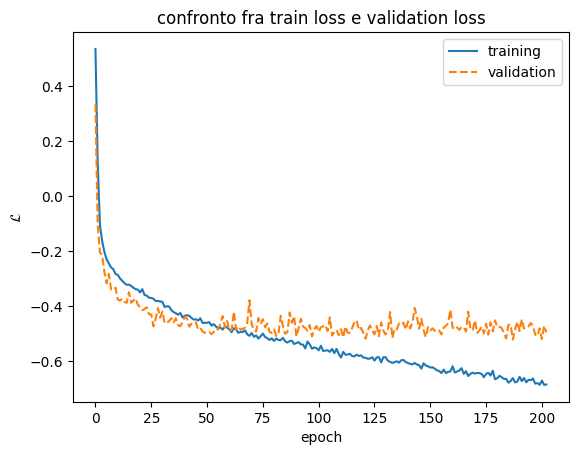

In [94]:
# realizzazione grafico

epoche=np.arange(epoch_best_model)

plt.plot(epoche,train_value[:epoch_best_model],label='training')
plt.plot(epoche,valid_value[:epoch_best_model],ls='--',label='validation')

plt.legend()
plt.title("confronto fra train loss e validation loss")
plt.xlabel("epoch")
plt.ylabel("$\mathcal{L}$")
#plt.loglog(nonpositive='clip')

plt.show()

In [95]:
test_loader = create_dataset('test', f_SFRD, f_params, batch_size, seed) #test data

# caricamento del best model e spostamento alla GPU
model.load_state_dict(torch.load(f_model))
model.to(device=device)

# test
SFRD_values=np.zeros((int(SFRD.shape[0]*0.15),100), dtype=np.float32)
params_true = np.zeros((int(params.shape[0]*0.15),6), dtype=np.float32)
params_NN = np.zeros((int(params.shape[0]*0.15),6), dtype=np.float32)
sig_NN = np.zeros((int(params.shape[0]*0.15),6), dtype=np.float32)

offset = 0
test_loss, points = 0.0, 0
model.eval()

counter=0
for SFRD_test, params_test in test_loader:
    with torch.no_grad():

        bs = SFRD_test.shape[0]

        # spostamento dei dati alla GPU
        SFRD_test = SFRD_test.to(device)
        params_test = params_test.to(device)

        # calcolo dei valori previsti dalla rete
        params_sig_pred  = model(SFRD_test)

        # memorizzazione dei valori reali e calcolati dei parametri
        # spostamento dei dati alla CPU e traduzione in array Numpy

        SFRD_values[counter:counter+bs,:]=SFRD_test.cpu().numpy()
        params_true[counter:counter+bs,:]= params_test.cpu().numpy()
        params_NN[counter:counter+bs,:]= params_sig_pred[:, ::2].cpu().numpy()
        sig_NN[counter:counter+bs,:] = params_sig_pred[:, 1::2].cpu().numpy()

        # compute cumulative loss and number of examples used
        test_loss += (loss_func(params_sig_pred, params_test))
        points += SFRD_test.shape[0]

        counter += bs

# calcolo del valore medio
test_loss /= points

print('test loss = %.3e'%test_loss)

test loss = -5.002e-01


La seguente figura, creata su modello di quella mostrata del caso precedente, presenta il confronto tra i valori veri e predetti per i parametri da studiare. La banda grigia sovrapposta alla retta $y = x$ è indicativa dell'errore associato alla stima di tali parametri e ha lo spessore di 2 deviazioni standard (una per lato). Si precisa infine che il valore dell'incertezza associata ad ogni parametro è stato ottenuto facendo una media sui risultati delle stime effettuate dalla rete neuronale.

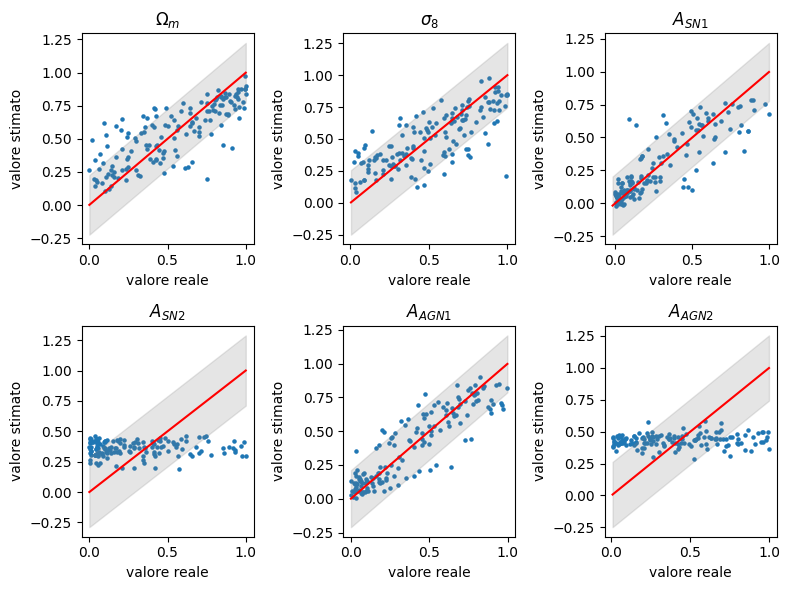

In [97]:
# produzione del grafico

label = ['$\Omega_m$', "$\sigma_8$", "$A_{SN1}$", "$A_{SN2}$", "$A_{AGN1}$", "$A_{AGN2}$"]

plt.figure(figsize=(8, 6))

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.scatter(params_true[:, i], params_NN[:,i], s = 5)

    limits = [min(np.min(params_true[:, i]), np.min(params_NN[:, i])),
              max(np.max(params_true[:, i]), np.max(params_NN[:, i]))]
    sig_mean[i] = np.mean(sig_NN[i])

    plt.plot(limits, limits, color='red') # la retta fa riferimento a una stima perfetta
    plt.fill_between(limits, limits-3*sig_mean[i], limits+3*sig_mean[i], color='gray', alpha=0.2)

    plt.title(label[i])
    plt.xlabel('valore reale')
    plt.ylabel('valore stimato')

plt.tight_layout()
plt.show()